# Habitat Simulation with NoMaD Navigation - Notebook Version

This notebook demonstrates how to run the NoMaD policy in Habitat simulation.

In [1]:
# Import the main module
import sys


from src.habitat_main import HabitatSimulator, NoMaDPolicy
from src.controller.action_conversion import WaypointToActionConverter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display
import imageio

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


pybullet build time: Sep 30 2025 00:53:55


## Configuration

Set your paths here:

In [6]:
# Configuration
SCENE_PATH = "/home/liuxh/vln/nomad-habitat/habitat-sim/data/versioned_data/mp3d_example_scene_1.1/17DRP5sb8fy/17DRP5sb8fy.glb"
# SCENE_PATH = "habitat-sim/data/scene_datasets/habitat-test-scenes/skokloster-castle.glb"
SCENE_PATH = "../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/wcojb4TFT35.basis.glb"
# SCENE_PATH = "habitat-sim/data/scene_datasets/habitat-test-scenes/apartment_1.glb"
MODEL_CONFIG = "../algorithm/visualnav-transformer/train/config/nomad.yaml"
MODEL_WEIGHTS = (
    "../algorithm/visualnav-transformer/deployment/model_weights/nomad.pth"
)
ROBOT_CONFIG = "../algorithm/src/config/robot.yaml"


NUM_STEPS = 600
WAYPOINT_INDEX = 2
NUM_SAMPLES = 8
CONTEXT_WARMUP = 12
DEVICE = "cuda"
FORWARD_DISTANCE = 0.1
TURN_ANGLE = 5

## Initialize Simulator and Policy

In [7]:
# Initialize Habitat simulator
print("Initializing Habitat simulator...")
habitat_sim = HabitatSimulator(scene_path=SCENE_PATH, enable_physics=True, resolution=(480, 640))
habitat_sim.initialize()
print("✓ Habitat simulator initialized.")

# Initialize NoMaD policy
print("Initializing NoMaD policy...")
policy = NoMaDPolicy(
    model_config_path=MODEL_CONFIG, model_weights_path=MODEL_WEIGHTS, device=DEVICE
)
print("✓ NoMaD policy initialized.")

Initializing Habitat simulator...
✓ Habitat simulator initialized.
Initializing NoMaD policy...
Using device: cuda
Loading model from ../algorithm/visualnav-transformer/deployment/model_weights/nomad.pth


[13:44:45:468089]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[13:44:45:468687]:[Warning]:[Scene] SemanticScene.h(331)::checkFileExists : ::loadSemanticSceneDescriptor: File `../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/wcojb4TFT35.basis.scn` does not exist.  Aborting load.
[13:44:45:468764]:[Warning]:[Scene] SemanticScene.cpp(123)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/wcojb4TFT35.basis.scn` nor constructed filename : `../habitat-sim/data/scene_datasets/hm3d/val/00802-wcojb4TFT35/info_semantic.json` exist on disk.
[13:44:45:468808]:[Error]:[Scene] SemanticScene.cpp(139)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `../habi

✓ NoMaD policy initialized.


In [ ]:
habitat_sim.agent.agent_config.action_space["turn_right"].actuation.amount = TURN_ANGLE
habitat_sim.agent.agent_config.action_space["turn_left"].actuation.amount = TURN_ANGLE
habitat_sim.agent.agent_config.action_space["move_forward"].actuation.amount = FORWARD_DISTANCE
habitat_sim.agent.agent_config.action_space

{'move_forward': ActionSpec(name='move_forward', actuation=ActuationSpec(amount=0.1, constraint=None)),
 'turn_left': ActionSpec(name='turn_left', actuation=ActuationSpec(amount=5, constraint=None)),
 'turn_right': ActionSpec(name='turn_right', actuation=ActuationSpec(amount=5, constraint=None))}

# 暂定目标：遥感图像处理

In [ ]:
from src.controller.action_conversion import WaypointToActionConverter
from habitat_sim.utils.common import quat_from_two_vectors
control = WaypointToActionConverter()

## Run Exploration

In [ ]:

# Recording containers
habitat_sim.sim.reset(habitat_sim.sim._default_agent_id)
traj_frames = []
trajectory_grid_points = []
trajectory_grid_waypoints = []
obs_video = []
print(f"Starting exploration for {NUM_STEPS} steps...")
control = WaypointToActionConverter()
# Exploration loop
for step in range(NUM_STEPS ):
    # Get current observation
    rgb_img = habitat_sim.get_observation()

    # Add to policy context
    policy.add_observation(rgb_img)

    # Get agent position and update trajectory
    position = habitat_sim.get_agent_position()
    grid_loc = habitat_sim.world_to_map(position)
    trajectory_grid_points.append(grid_loc)

    # Predict action after enough context
    action = []
    cumulate_action = []
    if step < CONTEXT_WARMUP:
        # Random exploration during warmup
        action.append(np.random.choice(["move_forward", "turn_left", "turn_right"]))
        if step % 10 == 0:
            print(f"Step {step}: Warmup - {action}")
    else:
        # Use policy to predict waypoint
        if step % 4 == 0:
            result = policy.predict_waypoint(waypoint_index=WAYPOINT_INDEX, num_samples=NUM_SAMPLES)
            waypoint, trajectory = result
            trajectory_grid_waypoints.append(waypoint)

        if result is not None:
            action = control.sequential_convert(waypoint=waypoint)

            if step % 4 == 0:
                print(f"Step {step}: Predicted waypoint {waypoint} -> {action}")

    # Execute action
    for act in action:
        habitat_sim.step(act)

    # Visualize
    # Draw trajectory on map
    map_frame = habitat_sim.draw_trajectory(trajectory_grid_points)

    # Resize and combine frames
    # h_rgb, w_rgb = rgb_img.shape[:2]
    # h_map, w_map = map_frame.shape[:2]
    # scale = h_rgb / h_map
    # new_w_map = int(w_map * scale)
    # map_frame_resized = cv2.resize(map_frame, (new_w_map, h_rgb))
    obs_video.append(rgb_img)
    traj_frames.append(map_frame)
    # Stack side-by-side
    # combined_frame = np.hstack((rgb_img, map_frame_resized))
    # traj_frames.append(combined_frame)


print("✓ Exploration completed.")

Starting exploration for 600 steps...
Step 0: Warmup - ['move_forward']
Step 10: Warmup - ['turn_right']
Inference time: 0.217s
Step 12: Predicted waypoint [3.993866   0.39024448] -> ['turn_left', 'move_forward']
Inference time: 0.072s
Step 16: Predicted waypoint [3.4981723 0.7677274] -> ['turn_left', 'turn_left', 'turn_left', 'move_forward']
Inference time: 0.071s
Step 20: Predicted waypoint [ 3.431867   -0.11760116] -> ['move_forward']
Inference time: 0.074s
Step 24: Predicted waypoint [ 2.0333827  -0.14409995] -> ['turn_right', 'move_forward']
Inference time: 0.070s
Step 28: Predicted waypoint [ 3.144391  -0.6131773] -> ['turn_right', 'turn_right', 'turn_right', 'move_forward']
Inference time: 0.070s
Step 32: Predicted waypoint [3.9622455  0.12936592] -> ['move_forward']
Inference time: 0.071s
Step 36: Predicted waypoint [4.016344   0.28771114] -> ['turn_left', 'move_forward']
Inference time: 0.071s
Step 40: Predicted waypoint [3.5681596  0.77906036] -> ['turn_left', 'turn_left', 't

## Save and Display Video

In [ ]:
# Save video
output_path = "src/results/habitat_mapframe_notebook.mp4"
print(f"Saving video to {output_path}...")
imageio.mimsave(output_path, traj_frames, fps=10)
print(f"✓ Video saved to {output_path}")

# Display in notebook
display(Video(output_path, width=1200))

Saving video to src/results/habitat_mapframe_notebook.mp4...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (214, 415) to (224, 416) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✓ Video saved to src/results/habitat_mapframe_notebook.mp4


In [ ]:
# Save video
output_path1 = "src/results/habitat_obs_notebook.mp4"
print(f"Saving video to {output_path1}...")
imageio.mimsave(output_path1, obs_video, fps=10)
print(f"✓ Video saved to {output_path1}")

# Display in notebook
display(Video(output_path1, width=1200))

Saving video to src/results/habitat_obs_notebook.mp4...
✓ Video saved to src/results/habitat_obs_notebook.mp4


## Visualize a Sample Frame

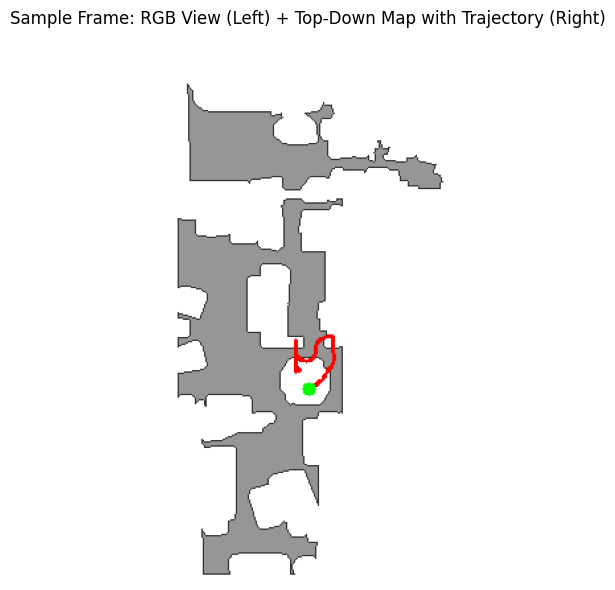

In [ ]:
# Show a sample frame
sample_frame = traj_frames[len(traj_frames) // 2]

plt.figure(figsize=(15, 6))
plt.imshow(sample_frame)
plt.axis("off")
plt.title("Sample Frame: RGB View (Left) + Top-Down Map with Trajectory (Right)")
plt.tight_layout()
plt.show()

In [ ]:
state=habitat_sim.sim.agents[0].get_state()
state.position+= np.array([0.1,0,0])
habitat_sim.sim.agents[0].set_state(state)
habitat_sim.sim.agents[0].get_state().position

array([ 1.3380581, -2.20508  , -7.3195477], dtype=float32)

## Cleanup

In [ ]:
# # Close simulator
# habitat_sim.close()
# print("✓ Simulator closed.")